## Question 3 :  Heston Model Implied Volatility

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import time

## Initializing Parameters

In [2]:
S0 = 100
r = 0.05
K = np.arange(90, 121).reshape(1,31)      #column vector
T = 3/12      # time to maurity
dt = 1/365    #Setting step size delta t = 1/365

## CIR Parameters
X0 = 0.2
kappa = 3
theta = 0.2
rho = np.array([-0.2, 0, 0.2])
sigma = np.sqrt(2*theta*kappa) * np.array([0.35, 0.75, 1])

M = 20000 # number of monter carlo simulations
N = int(T/dt)+1

## Defining Relevant Functions

## Black-Scholes Option Pricing

In [3]:
def bsm_price(S, k, r, t, sigma, option='call'):
    '''Calculate Black-Scholes option price'''
    d1 = (np.log(S/k) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    if option == 'call':
        price = S*norm.cdf(d1) - k*np.exp(-r*t)*norm.cdf(d2)
    else:
        price = k*np.exp(-r*t)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    return price

## Black Scholes Vega

In [4]:
def bsm_vega(S, k, r, t, sigma):
    '''Calculate Black-Scholes option vega'''
    d1 = (np.log(S/k) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    vega = S*np.sqrt(t)*norm.pdf(d1)
    return vega

## Implied Volatility Using Newton Raphson  Model

In [5]:
def implied_vol(S, k, r, t, option_price, option='call'):
    '''Calculate implied volatility using the Newton-Raphson method'''
    tol = 1e-5
    max_iter = 10000
    sigma = 0.5
    
    for i in range(max_iter):
        price = bsm_price(S, k, r, t, sigma, option)
        vega = bsm_vega(S, k, r, t, sigma)
        diff = price - option_price
        
        if abs(diff) < tol:
            break
        
        sigma = sigma - diff/vega
    
    return sigma

## Heston Model Implementation

## Simulating Stock Prices using Heston Model

In [6]:
# Initializing necessary arrays
stock_price = np.zeros((1,M))
strike = np.tile(K,(M,1)) 
call = np.zeros((1,K.shape[1]))
discount = math.exp(-r*T)  
np.random.seed(42)

for sig in sigma:
    for rh in rho:
        ## Euler - Mariyama Process
        X = np.zeros((M,N))
        X[:,0] = X0
        Y = np.zeros((M,N))
        Y[:,0] = np.log(S0)

        for t in range(1,N):
            dW = np.random.normal(0,1,size = (M,1))*np.sqrt(dt)   # standard brownian motion
            dB = np.random.normal(0,1,size = (M,1))*np.sqrt(dt)     # standard brownian motion
            X[:,t] = (1 - kappa * dt) * X[:,t-1].reshape((M,1)).squeeze() + \
                     np.full((M,1),kappa * theta * dt).squeeze() + \
                     (sig * np.sqrt(np.maximum(X[:,t-1], 0)).reshape(M,1)*dW).reshape((M,1)).squeeze() 

            ## Y = ln(S)
            Y[:,t] = Y[:,t-1] + ((np.full((M,1),r) - 0.5 * X[:,t-1].reshape(M,1))*dt).reshape(M,1).squeeze() + \
                     ((np.sqrt(np.maximum(X[:,t-1],0).reshape(M,1))*(rh*dW + np.sqrt(1-rh**2) * dB)).reshape(M,1).squeeze())

        
        # stock prices for M simulations of all 9 graphs 
        stock_price = np.append(stock_price,np.exp(Y[:,-1]).reshape(1,M), axis = 0)

        S = np.repeat(np.exp(Y[:,-1]).reshape(M,1),31,axis = 1)
        call = np.append(call,np.mean(np.maximum(S - strike,0),axis = 0).reshape(1,31),axis = 0)

stock_price = stock_price[1:,:]

call = call[1:,:]


## Implied Volatility Calculations

In [7]:
## Calculating Implied Volatility using Newton Rahpson Method

num = 0
for i, c in enumerate(call):
    ls = []
    for j, k in enumerate(K[0]):
        imp_vol = implied_vol(S0,float(k),r,T,float(call[i,j]),'call')
        ls.append(imp_vol)
    if (num==0):
        implied_volatility = np.array(ls).reshape(1,31)
        num = 1
    else:
        new = np.array(ls).reshape(1,31)   
        implied_volatility = np.append(implied_volatility,new,axis = 0)
            

## Plotting Implied Volatility

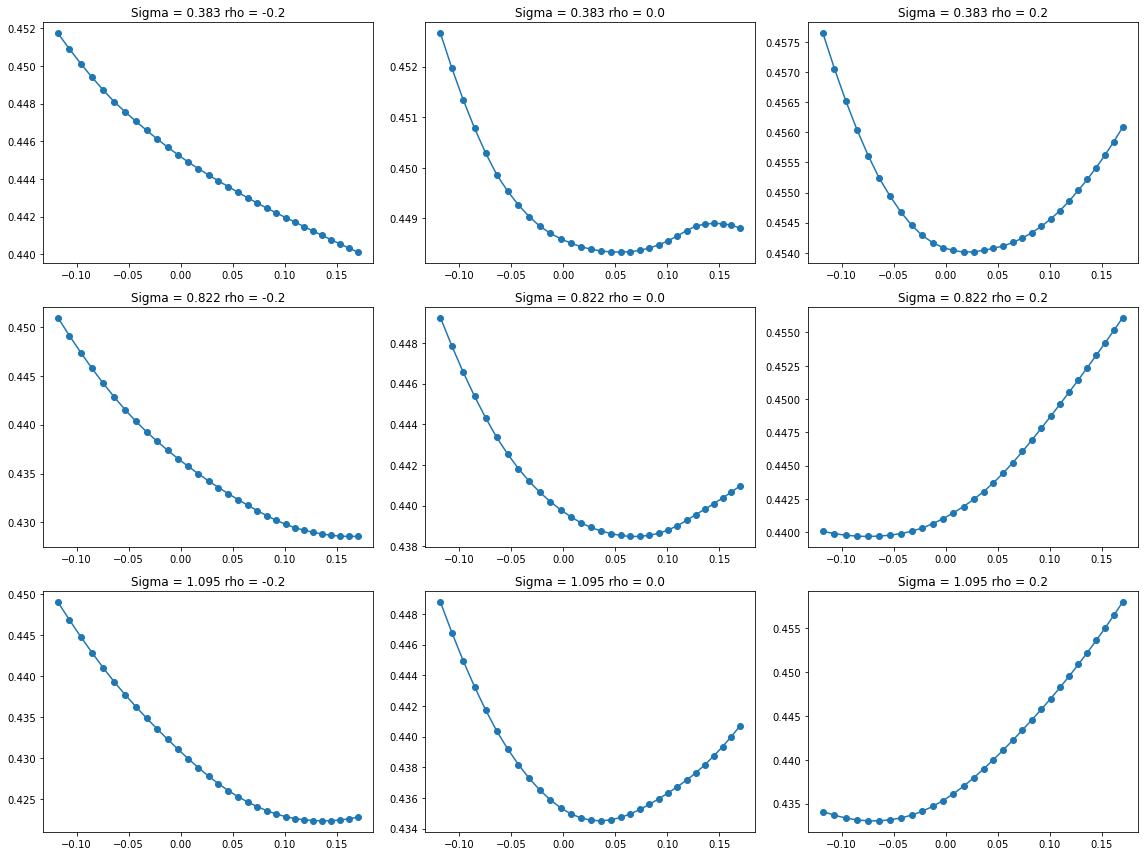

In [8]:
fig, axs = plt.subplots(3, 3, figsize = (16,12))

for i, sig in enumerate(sigma):
    for j, rh in enumerate(rho):
        # plot the i,j graph in the subplot
        x = np.log(K*np.exp(-r*T)/S0).reshape(1,31).tolist()
        y = implied_volatility[i*3+j,:].reshape(1,31).tolist()
        y = savgol_filter(y, window_length=11, polyorder=2)
        axs[i, j].plot(x[0],y[0],'o-')
        axs[i, j].set_title('Sigma = '+ str(round(sig,3)) +' rho = ' + str(rh))

# adjust the layout of the subplots
fig.tight_layout()

# show the plot
plt.show()